# BERT4REC with genres embed

### Import Libs

In [2]:
import math
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import warnings

### Make config

In [3]:
config = {
    'data_path' : '/kaggle/input/movielens-20m-dataset', 
    'max_len' : 80,
    'hidden_units' : 256, # Embedding 
    'num_heads' : 2, # Multi-head layer 
    'num_layers': 2, # block encoder layer
    'dropout_rate' : 0.1, # dropout
    'lr' : 0.001,
    'batch_size' : 256,
    'num_epochs' : 10,
    'num_workers' : 2,
    'mask_prob' : 0.15, 
}

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Work with Data

Опишем класс, который переделает исходный датасет, в последовательности просмотров фильмов

In [5]:
class MakeSequenceDataSet():
    """
    SequenceData
    
    Переделывет исходную таблицу (юзер: просмотренный фильм) в таблицу (юзер: последовательность просмотренных фильмов)
    """
    def __init__(self, data_path):
        
        print('Reading data...')
        self.df = pd.read_csv(os.path.join(data_path, 'rating.csv'))
        self.movies = pd.read_csv(os.path.join(data_path, 'movie.csv'))
        
        
        print('Applying genres...')
        
        self.genres = [
            "Action",
            "Adventure",
            "Animation",
            "Children's",
            "Comedy",
            "Crime",
            "Documentary",
            "Drama",
            "Fantasy",
            "Film-Noir",
            "Horror",
            "Musical",
            "Mystery",
            "Romance",
            "Sci-Fi",
            "Thriller",
            "War",
            "Western",
        ]
        
        for genre in self.genres:
            self.movies[genre] = self.movies["genres"].apply(
                lambda values: int(genre in values.split("|"))
            )
        
        self._movie_genres = self.movies[self.genres].to_numpy()
        
        print('Generate encoder and decoder...')
        self.item_encoder, self.item_decoder = self.generate_encoder_decoder(self.movies['movieId'])
        self.user_encoder, self.user_decoder = self.generate_encoder_decoder(self.df['userId'])
        self.num_item, self.num_user = len(self.item_encoder), len(self.user_encoder)

        self.df['item_idx'] = self.df['movieId'].apply(lambda x : self.item_encoder[x] + 1)
        self.df['user_idx'] = self.df['userId'].apply(lambda x : self.user_encoder[x])
        
        self.df = self.df.sort_values(['user_idx', 'timestamp']) 
        
        print('Generate sequence data...')
        self.user_train, self.genres_seq, self.user_valid = self.generate_sequence_data()
        
        print('Finish!!!')

    def generate_encoder_decoder(self, col) -> dict:
        """
        encoder, decoder

        Args:
            col (str): columns
        Returns:
            dict: encoder, decoder
        """

        encoder = {}
        decoder = {}
        ids = col.unique()

        for idx, _id in enumerate(ids):
            encoder[_id] = idx
            decoder[idx] = _id

        return encoder, decoder
    
    def movie_genres(self, idx):
        return self._movie_genres[idx-1].tolist()
        
    
    def generate_sequence_data(self) -> dict:
        """
        sequence_data

        Returns:
            dict: train user sequence / valid user sequence
        """
        users = defaultdict(list)
        user_train = {}
        genres_seq = {}
        user_valid = {}
        group_df = self.df.groupby('user_idx')
        for user, item in group_df:
            users[user].extend(item['item_idx'].tolist())
            
        
        for user in users:
            user_train[user] = users[user][:-1]
            genres_seq[user] = [self.movie_genres(i) for i in user_train[user]]
            user_valid[user] = users[user][-1]

        return user_train, genres_seq, user_valid
    
    def get_train_valid_data(self):
        return self.user_train, self.genres_seq, self.user_valid

Дальше опишем класс Dataset для обучения. Сам датасет будет состоять из пользователей, и последовательностей их просмотров. При этом при обучении модели, подаваемая последовательность модифицируется следующим образом:
- Выбирается 15% случайных токенов из последоваетельности
- Из выбранных токенов:
    - 80% заменяется токеном маски
    - 10% заменяется случайным токеном 
    - 10% остаются без изменений

В дополнении к последовательности просмотренных фильмов, есть последовательность жанров к просмотренным фильмам, которая модифицируется тем же способом, что и последовательность фильмов.

Таким образом, один элемент из обучающей выборки выглядит следующим образом:

```python
Dataset[i] = item_sequence, genres_sequence, labels
```
`item_sequenceitem_sequence` - измененная последовательность фильмов [1 x n] (n - длина последовательности)

`genres_sequencegenres_sequence` - измененная последовательность жанров к фильмам [m x n] (m - число жанров, нашем случае m = 18)

`labels` - истинная последовательность просмотренных фильмов, т.е. то что должна вернуть модель [1 x n]
    

In [29]:
class BERTRecDataSet(Dataset):
    def __init__(self, user_train, movie_genres, max_len, num_user, num_item, mask_prob):
        self.user_train = user_train
        self.movie_genres = movie_genres
        self.max_len = max_len
        self.num_user = num_user
        self.num_item = num_item
        self.mask_prob = mask_prob
        self._all_items = set([i for i in range(1, self.num_item + 1)])

    def __len__(self):
        return self.num_user

    def __getitem__(self, user): 
        
        user_seq = self.user_train[user]
        genre_seq = self.movie_genres[user]
        tokens = []
        genres_seq = []
        labels = []
        
        for s, g in zip(user_seq[-self.max_len:], genre_seq[-self.max_len:]):
            prob = np.random.random()
            if prob < self.mask_prob:
                prob /= self.mask_prob
                if prob < 0.8:
                    # masking
                    tokens.append(self.num_item + 1) # (index, genres)  mask_index: num_item + 1, 0: pad, 1~num_item: item index
                    genres_seq.append([1]*18)
                elif prob < 0.9:
                    # noise
                    rnd_token = self.random_neg_sampling(rated_item = user_seq, num_item_sample = 1)[0] # item random sampling
                    tokens.append(rnd_token)  
                    genres_seq.append([random.randint(0, 1) for _ in range(18)])
#                   genres_seq.append(self.movie_genres(rnd_token))
                else:
                    tokens.append(s)
                    genres_seq.append(g)
            else:
                tokens.append(s)
                genres_seq.append(g)
            labels.append(s)

        mask_len = self.max_len - len(tokens)
        
        tokens = [0] * mask_len + tokens
        genres_seq = [[0]*18] * mask_len + genres_seq
        labels = [0] * mask_len + labels

        return torch.LongTensor(tokens), torch.Tensor(genres_seq), torch.LongTensor(labels)

    def random_neg_sampling(self, rated_item : list, num_item_sample : int):
        nge_samples = random.sample(range(1, self.num_item + 1), num_item_sample)
        return nge_samples

In [31]:
make_sequence_dataset = MakeSequenceDataSet(config['data_path'])

Reading data...
Applying genres...
Generate encoder and decoder...
Generate sequence data...
Finish!!!


In [32]:
user_train, movie_genres, user_valid = make_sequence_dataset.get_train_valid_data()

In [33]:
bert4rec_dataset = BERTRecDataSet(
    user_train = user_train,
    movie_genres = movie_genres,
    max_len = config['max_len'], 
    num_user = make_sequence_dataset.num_user, 
    num_item = make_sequence_dataset.num_item,
    mask_prob = config['mask_prob'],
)

In [34]:
data_loader = DataLoader(
    bert4rec_dataset, 
    batch_size = config['batch_size'], 
    shuffle = True, 
    pin_memory = True,
    num_workers = 4# config['num_workers'],
)

In [35]:
%%time
d = next(iter(data_loader))

CPU times: user 88.3 ms, sys: 664 ms, total: 753 ms
Wall time: 1.36 s


## Model

In [36]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()

        # Compute the positional encodings once in log space.
        self.pe = nn.Embedding(max_len, d_model)

    def forward(self, x):
        batch_size = x.size(0)
        return self.pe.weight.unsqueeze(0).repeat(batch_size, 1, 1)

class TokenEmbedding(nn.Embedding):
    def __init__(self, vocab_size, embed_size=512):
        super().__init__(vocab_size, embed_size, padding_idx=0)
        
class GenresEmbedding(nn.Module):
    def __init__(self, genres_size, embed_size=512):
        super().__init__()
        self.linear_1 = nn.Linear(genres_size, genres_size*2)
        self.act = nn.ReLU()
        self.linear_2 = nn.Linear(genres_size*2, embed_size)
    def forward(self, genres_vec):
        x = self.linear_2(self.act(self.linear_1(genres_vec)))
        return x

In [37]:
class BERTEmbedding(nn.Module):
    """
    BERT Embedding which is consisted with under features
        1. TokenEmbedding : normal embedding matrix
        2. PositionalEmbedding : adding positional information using sin, cos
        2. SegmentEmbedding : adding sentence segment info, (sent_A:1, sent_B:2)

        sum of all these features are output of BERTEmbedding
    """

    def __init__(self, vocab_size, genres_size, embed_size, max_len, dropout=0.1):
        """
        :param vocab_size: total vocab size
        :param embed_size: embedding size of token embedding
        :param dropout: dropout rate
        """
        super().__init__()
        self.token = TokenEmbedding(vocab_size=vocab_size, embed_size=embed_size)
        self.position = PositionalEmbedding(max_len=max_len, d_model=embed_size)
        self.genres_emb = GenresEmbedding(genres_size=genres_size, embed_size=embed_size)
        # self.segment = SegmentEmbedding(embed_size=self.token.embedding_dim)
        self.dropout = nn.Dropout(p=dropout)
        self.embed_size = embed_size

    def forward(self, sequence, genres):
        x = self.token(sequence) + self.position(sequence) + self.genres_emb(genres)
        return self.dropout(x)

In [38]:
class Attention(nn.Module):
    """
    Compute 'Scaled Dot Product Attention
    """

    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn

In [39]:
class MultiHeadedAttention(nn.Module):
    """
    Take in model size and number of heads.
    """

    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, attn = self.attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)

In [40]:
class GELU(nn.Module):
    """
    Paper Section 3.4, last paragraph notice that BERT used the GELU instead of RELU
    """

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

In [41]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()

    def forward(self, x):
        return self.w_2(self.dropout(self.activation(self.w_1(x))))

In [42]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [43]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [44]:
class TransformerBlock(nn.Module):
    """
    Bidirectional Encoder = Transformer (self-attention)
    Transformer = MultiHead_Attention + Feed_Forward with sublayer connection
    """

    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        """
        :param hidden: hidden size of transformer
        :param attn_heads: head sizes of multi-head attention
        :param feed_forward_hidden: feed_forward_hidden, usually 4*hidden_size
        :param dropout: dropout rate
        """

        super().__init__()
        self.attention = MultiHeadedAttention(h=attn_heads, d_model=hidden, dropout=dropout)
        self.feed_forward = PositionwiseFeedForward(d_model=hidden, d_ff=feed_forward_hidden, dropout=dropout)
        self.input_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.output_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask):
        x = self.input_sublayer(x, lambda _x: self.attention.forward(_x, _x, _x, mask=mask))
        x = self.output_sublayer(x, self.feed_forward)
        return self.dropout(x)

In [45]:
class BERT(nn.Module):
    def __init__(self, bert_max_len, num_items, genres_size, bert_num_blocks, bert_num_heads,
                 bert_hidden_units, bert_dropout):
        super().__init__()

        # fix_random_seed_as(args.model_init_seed)
        # self.init_weights()

        max_len = bert_max_len
        num_items = num_items
        n_layers = bert_num_blocks
        heads = bert_num_heads
        self.vocab_size = num_items + 2
        self.genres_size = genres_size
        hidden = bert_hidden_units
        self.hidden = hidden
        dropout = bert_dropout

        # embedding for BERT, sum of positional, segment, token embeddings
        self.embedding = BERTEmbedding(vocab_size=self.vocab_size, genres_size=self.genres_size, 
                                       embed_size=self.hidden, max_len=max_len, dropout=dropout)

        # multi-layers transformer blocks, deep network
        self.transformer_blocks = nn.ModuleList(
            [TransformerBlock(hidden, heads, hidden * 4, dropout) for _ in range(n_layers)])
        self.out = nn.Linear(hidden, num_items + 1)
        
    def forward(self, x, genres):
        mask = (x > 0).unsqueeze(1).repeat(1, x.size(1), 1).unsqueeze(1)

        # embedding the indexed sequence to sequence of vectors
#         print(x.shape)
        x = self.embedding(x, genres)

        # running over multiple transformer blocks
        for transformer in self.transformer_blocks:
            x = transformer.forward(x, mask)
        
        x = self.out(x)
        return x

    def init_weights(self):
        pass

Принцип работы модели:
1) На вход модели дается последовательность просмотренных пользователем фильмов, а также последовательность жанров к просмотренным фильмам. Выходом модели является последовательность логитов просмотренных фильмов.

2) При обучении модели, мы учим ее предсказывать всю последовательность, так чтобы она умела отличать замаскированные токены, и выдавала вместо них верные токены.

3) При использовании модели к последовательности просмотренных фильмов в конце добавляется токен маски, и модель выдает последовательность. Последний элемент в этой последовательности и будет фильмом, который мы рекомендуем.

Пример входных данных:

In [66]:
d

[tensor([[ 2781,  1270,  1871,  ...,   977,  1261,  1236],
         [    0,     0,     0,  ...,  1945, 27279,  2874],
         [ 3918,   477,  5520,  ...,  3488,     1,  1213],
         ...,
         [ 7036,  4965,  1018,  ..., 18243, 23962, 27279],
         [ 6272,  8288,  1191,  ..., 21847,  1626,  3074],
         [    0,     0,     0,  ..., 27279,  5918, 18939]]),
 tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 1., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 0., 0.,  ..., 0., 1., 0.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 0., 0.,  ..., 1., 0., 0.]],
 
         [[0., 0., 0.,  ..., 1., 0., 0.],
          [1., 1., 0.,  ..., 1., 0., 0.],
      

Пример выходных данных:

In [69]:
seq, genres, _ = d
output = model(seq.to(device), genres.to(device))
print(output)
print(output.shape)

tensor([[[ -8.5422,  -5.4320,   4.9123,  ...,   3.6532,  -9.2619,  -9.1001],
         [-15.4920,   3.2460,  13.3366,  ...,  -5.1515, -15.6036, -12.1992],
         [-19.1605,   7.7264,   0.2465,  ...,  -9.3140, -16.8155, -17.6128],
         ...,
         [-21.2962,  17.7182, -13.8596,  ..., -15.2490, -22.2687, -15.1653],
         [-16.7138,   7.0545,  -0.9313,  ...,  -1.2226, -19.2813, -15.7219],
         [-14.6697,   9.7919,   1.3526,  ..., -10.7712, -15.6676, -12.2431]],

        [[ -8.4310,   1.2240,  -1.5580,  ...,  -7.1140, -10.2753,  -8.8451],
         [ -6.6626,   1.8131,  -2.0980,  ...,  -7.3748,  -7.7107,  -7.0792],
         [ -7.8121,   2.2034,  -0.8836,  ...,  -6.8250,  -9.4855,  -8.3257],
         ...,
         [-23.0707,  10.3210,  -0.8103,  ..., -13.6837, -23.2989, -17.5869],
         [ -9.7552,   5.8728,   2.2679,  ...,  -5.9364,  -9.5674,  -6.2546],
         [-14.6306,   1.9210,  -0.4067,  ..., -19.7957, -15.0196, -16.1584]],

        [[-21.6251,   5.7103,  -3.0020,  ...

In [46]:
from IPython.display import clear_output
from tqdm import tqdm, trange

In [63]:
device

'cuda'

In [60]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    loss_val = 0
    i = len(metrics['train_loss'])
    #, 'dev_ndcg': [] }
    for seq, genres, labels in data_loader:
        seq, genres, labels = seq.to(device), genres.to(device), labels.to(device)
        logits = model(seq, genres) # (bs, t, vocab)
        logits = logits.view(-1, logits.size(-1)) # (bs * t, vocab)
        labels = labels.view(-1) # (bs * t)
        
        optimizer.zero_grad()
        loss = criterion(logits, labels)
        
        loss_val += loss.item()
        metrics['train_loss'].append((i, loss.item()))

        loss.backward()
        optimizer.step()
        
       
        if i%100 == 0:
#             metrics['dev_ndcg'].append((i, compute_ndcg(model, dev_inp, dev_out)))
            clear_output(True)
            plt.figure(figsize=(5,4))
            for j, (name, history) in enumerate(sorted(metrics.items())):
#                 plt.subplot(1, len(metrics), j + 1)
                plt.title(name)
                plt.plot(*zip(*history))
                plt.grid()
            plt.show()
        i += 1
    
    loss_val /= len(data_loader)

    return loss_val

def evaluate(model, user_train, user_valid, max_len, data_loader, bert4rec_dataset, make_sequence_dataset):
    model.eval()

    NDCG = 0.0 # NDCG@10
    HIT = 0.0 # HIT@10

    num_item_sample = 100

    users = [user for user in range(make_sequence_dataset.num_user)]

    for user in tqdm(users):
        seq = (user_train[user] + [make_sequence_dataset.num_item + 1])[-max_len:] # mask last token
        genre_seq = ([make_sequence_dataset.movie_genres(i) for i in user_train[user]] + [[1]*18])[-max_len:]
        padding_len = max_len - len(seq)
#         print(genre_seq)
        seq = [0] * padding_len + seq
        genre_seq = [[0]*18] * padding_len + genre_seq
        
        rated = user_train[user] + [user_valid[user]]
        items = [user_valid[user]] + bert4rec_dataset.random_neg_sampling(rated_item = rated, num_item_sample = num_item_sample)
        
        with torch.no_grad():
            genre_seq = torch.Tensor([genre_seq]).to(device)
            seq = torch.LongTensor([seq]).to(device)
            
            predictions = -model(seq, genre_seq)
#             print(predictions.shape)
            predictions = predictions[0][-1][items] # sampling
#             print(predictions.shape)
            rank = predictions.argsort().argsort()[0].item() # label

        if rank < 10: #Top10
            NDCG += 1 / np.log2(rank + 2)
            HIT += 1

    NDCG /= len(users)
    HIT /= len(users)

    return NDCG, HIT


In [49]:
model = BERT(
    num_items = make_sequence_dataset.num_item,
    genres_size = 18,
    bert_hidden_units = config['hidden_units'], 
    bert_num_heads = config['num_heads'], 
    bert_num_blocks = config['num_layers'], 
    bert_max_len = config['max_len'], 
    bert_dropout = config['dropout_rate'], 
).to(device)
metrics = {'train_loss': []}

In [50]:
criterion = nn.CrossEntropyLoss(ignore_index=0) 
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

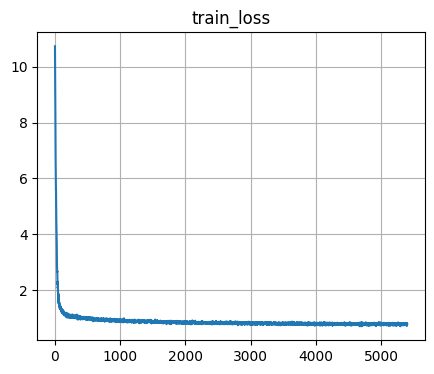

100%|██████████| 10/10 [38:30<00:00, 231.05s/it]

Epoch:  10| Train loss: 0.79314


In [51]:
loss_list = []
ndcg_list = []
hit_list = []
for epoch in tqdm(range(1, config['num_epochs'] + 1)):
    train_loss = train(
        model = model, 
        criterion = criterion, 
        optimizer = optimizer, 
        data_loader = data_loader)
    loss_list.append(train_loss)

    print(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}')

In [52]:
torch.save(model.state_dict(), os.path.join('/kaggle/working', 'weights_1.pth'))

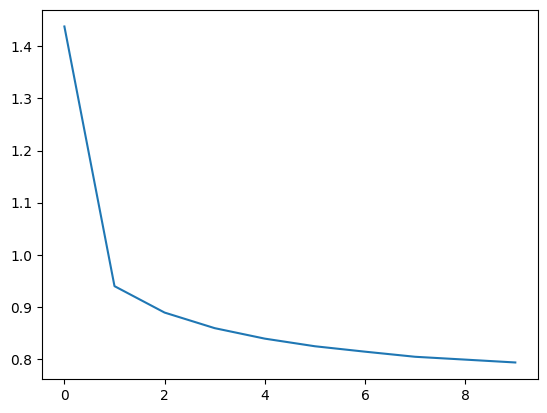

In [53]:
plt.plot(loss_list)

In [41]:
model.load_state_dict(torch.load(os.path.join('/kaggle/working', 'weights_1.pth')))
model.eval()

BERT(
  (embedding): BERTEmbedding(
    (token): TokenEmbedding(27280, 256, padding_idx=0)
    (position): PositionalEmbedding(
      (pe): Embedding(80, 256)
    )
    (genres_emb): GenresEmbedding(
      (linear_1): Linear(in_features=18, out_features=36, bias=True)
      (act): ReLU()
      (linear_2): Linear(in_features=36, out_features=256, bias=True)
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attention): MultiHeadedAttention(
        (linear_layers): ModuleList(
          (0-2): 3 x Linear(in_features=256, out_features=256, bias=True)
        )
        (output_linear): Linear(in_features=256, out_features=256, bias=True)
        (attention): Attention()
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (feed_forward): PositionwiseFeedForward(
        (w_1): Linear(in_features=256, out_features=1024, bias=True)
        (w_2): Linear(in_features=1024, out_features=256, bias=True)
  

In [61]:
ndcg, hit = evaluate(
    model = model, 
    user_train = user_train, 
    user_valid = user_valid, 
    max_len = config['max_len'],
    data_loader = None,
    make_sequence_dataset = make_sequence_dataset,
    bert4rec_dataset = bert4rec_dataset
)

100%|██████████| 138493/138493 [10:11<00:00, 226.33it/s]


In [64]:
print(f'NDCG@10: {ndcg}| HIT@10: {hit}')

NDCG@10: 0.7689098089142572| HIT@10: 0.9506617662986577
